# Total Roll Call
This notebook covers a lot of the exploratory analysis on the roll call votes. Many of charts and graphs in the gallery concerning `missing votes` were generated here. Information about senators' records and election years can also be found here.

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
bills = pd.read_csv('../data/all_bills.csv', index_col=0)
senators = pd.read_csv('../data/senators114.csv', index_col=0)

In [3]:
bills = bills[['vote_number', 'vote_date', 'issue', 'title', 'yea', 'nay', 'result', 'question']]
bills['vote_number'].iloc[339:] = bills.iloc[339:, :].vote_number.apply(lambda x: x+339) # fixes the numbers for the second session

In [4]:
bills['vote_date'].iloc[339:] = bills['vote_date'].iloc[339:].apply(lambda x: str(x)+'-2016')
bills['vote_date'].iloc[:339] = bills['vote_date'].iloc[:339].apply(lambda x: str(x)+'-2015')

In [5]:
# change dates to datetime objects
bills['vote_date'] = pd.to_datetime(bills.vote_date)

# clean
bills['question'] = bills.question.apply(lambda x: x.strip())

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 10

plt.style.use(style='fivethirtyeight')

## Outcomes
Let's take a look at the outcomes and the missed votes

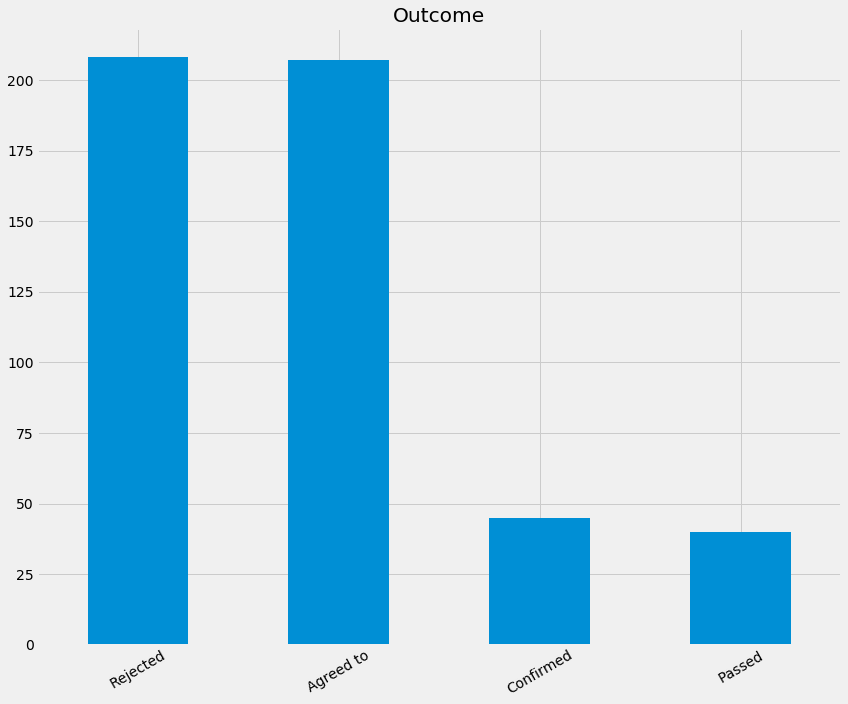

In [7]:
bills.result.value_counts()[:4].plot(kind='bar')
plt.title('Outcome')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../gallery/outcomes.png')
plt.show()

In [8]:
 (bills.result.value_counts() / 502) *100

Rejected           41.434263
Agreed to          41.235060
Confirmed           8.964143
Passed              7.968127
Veto Overridden     0.199203
Veto Sustained      0.199203
Name: result, dtype: float64

Great, the the bills are roughly evenly distributed between the classes. 
We know that a lot of senators and and states miss votes, but how many? What's the distribution like?

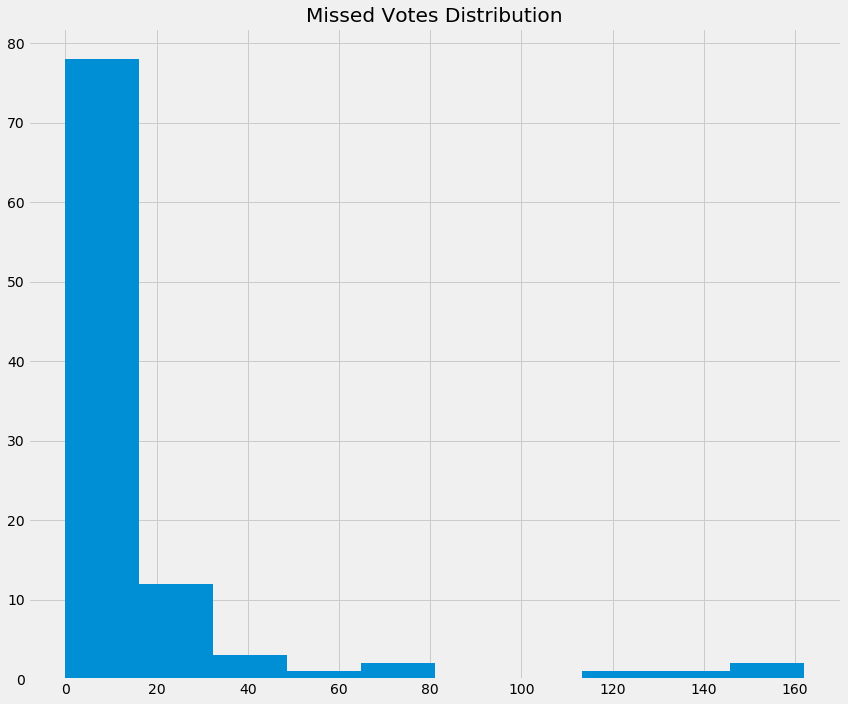

In [9]:
senators.missed_votes.plot(kind='hist')
plt.ylabel('')
plt.xlabel('')
plt.title('Missed Votes Distribution')
plt.tight_layout()
plt.savefig('../gallery/missed_hist.png')

The great majority of senators miss very few votes. Let's take a closer look at the senators. 

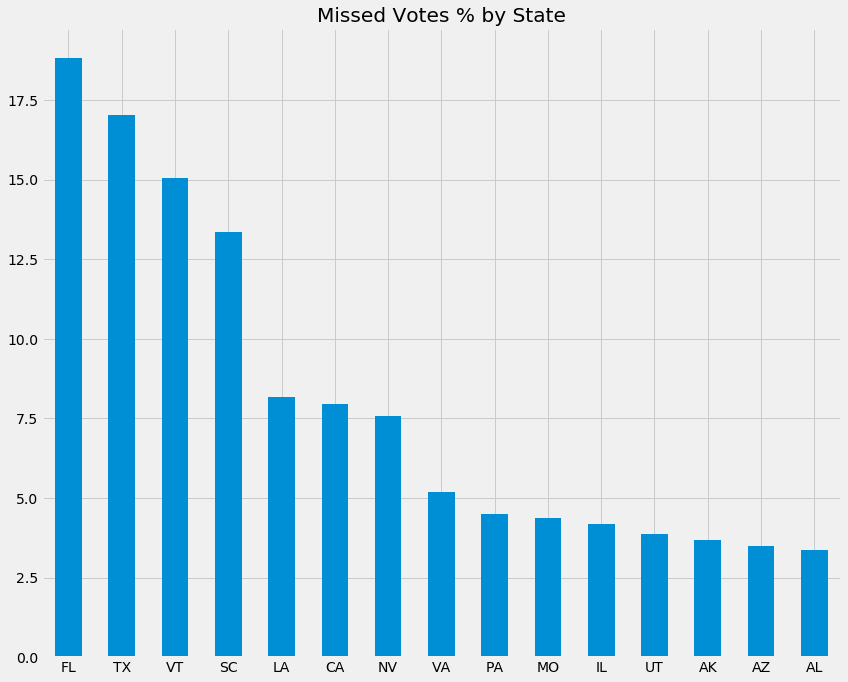

In [10]:
senators.pivot_table(index='state', values='missed_votes_pct').sort_values(ascending=False)[:15].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Missed Votes % by State')
plt.tight_layout()
plt.xlabel('')
plt.savefig('../gallery/missed_votes_by_state.png')
plt.show()

## The Senators

This is interesting, why do some states have much higher values than others? 

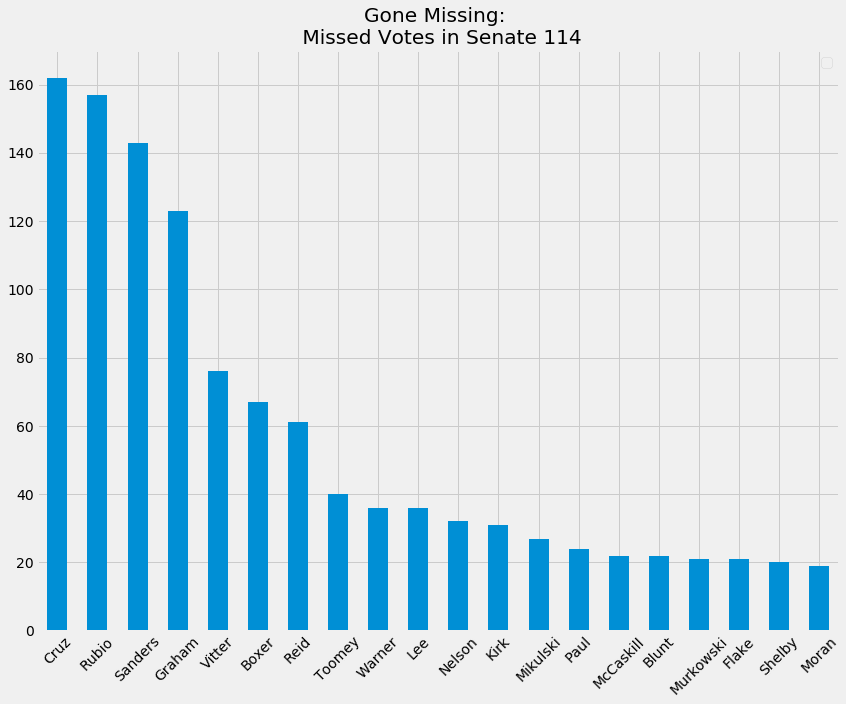

In [11]:
senators[['last_name', 'missed_votes']].sort_values(by='missed_votes', ascending=False)[:20].plot(kind='bar', x='last_name')
plt.xticks(rotation=45)
plt.title('Gone Missing: \n Missed Votes in Senate 114')
plt.legend('')
plt.xlabel('')
plt.tight_layout()
plt.savefig('../gallery/missed_votes_senators.png')
plt.show()

That makes sense -- Cruz, Rubio, Sanders, and Graham all ran for president this past election cycle. Running for office might result in missing more votes. One way to verify this would be to consider their voting records in other years. 

In [12]:
senators.head()

,lis_id,cspan_id,state,first_name,last_name,missed_votes,missed_votes_pct,next_election,party,senate_class,seniority,total_votes,votes_with_party_pct
0,S289,5,TN,Lamar,Alexander,14,2.79,2020,R,2,13,502,85.45
1,S340,95241,NH,Kelly,Ayotte,7,1.39,2016,R,3,5,502,79.39
2,S342,45465,MO,Roy,Blunt,22,4.38,2016,R,3,5,502,90.83
3,S223,2470,CA,Barbara,Boxer,67,13.35,2016,D,3,23,502,93.56
4,S307,5051,OH,Sherrod,Brown,11,2.19,2018,D,1,3,502,93.48


Does senate class year have anything to do with missing votes? What about next election year? 

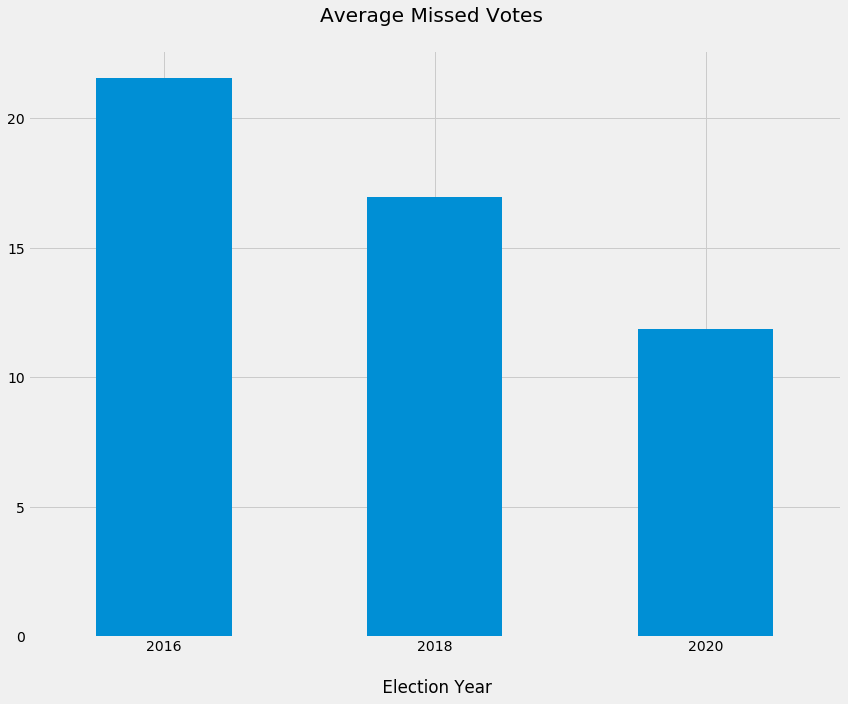

In [13]:
year_votes = senators.pivot_table(index='next_election', values='missed_votes').sort_values(ascending=False)
plt.style.use('fivethirtyeight')
year_votes.plot(kind='bar', title='Average Missed Votes \n')
plt.xlabel('\n Election Year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/missed_votes_electionyear.png')
plt.show()

As the election year draws closer, more senators miss more votes on average.

Is there a relationship between seniority and missed votes? 

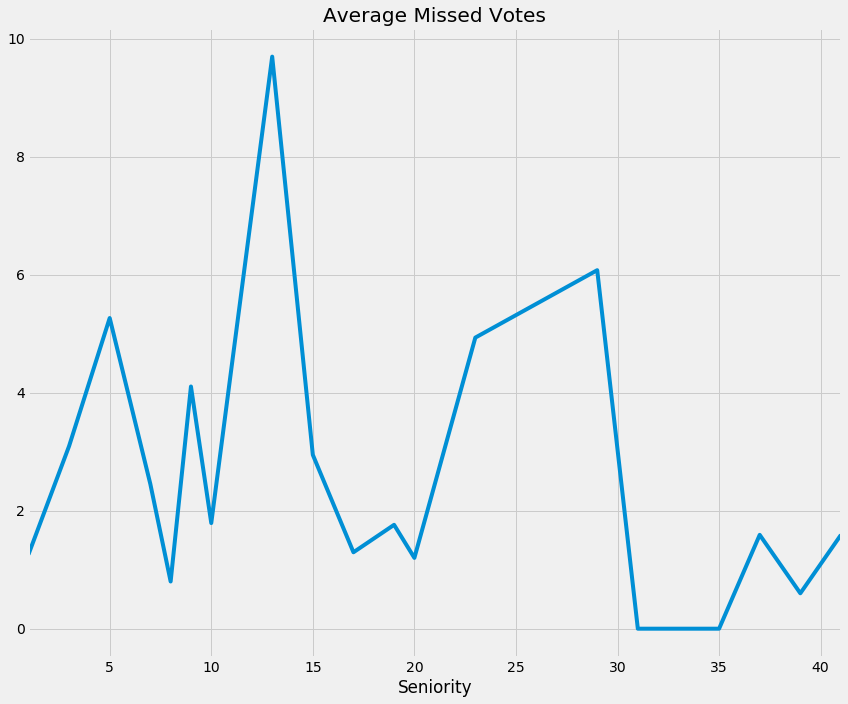

In [14]:
seniority_piv = senators.pivot_table(index='seniority', values='missed_votes_pct')
seniority_piv.plot()
plt.title('Average Missed Votes')
plt.tight_layout()
plt.xlabel('Seniority')
plt.tight_layout()
plt.savefig('../gallery/missed_seniority.png')
plt.show()

There does not seem to be a clear relationship between seniority and missed votes in the 114th Senate. 

Let's dig a little deeper into some of the distributions. 

In [15]:
# seniority distribution by party
import seaborn as sns

In [16]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[var].min() , df[ var ].max() ) )
    facet.add_legend()

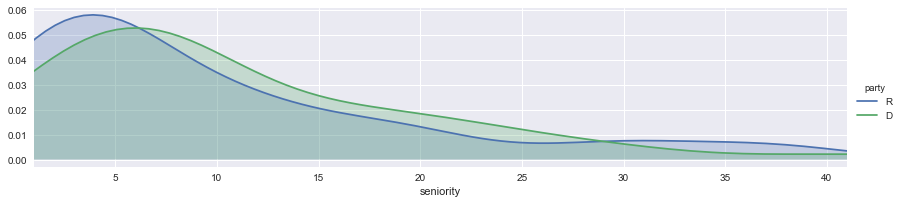

In [17]:
plot_distribution(senators[senators['party']!='I'], 'seniority','party')

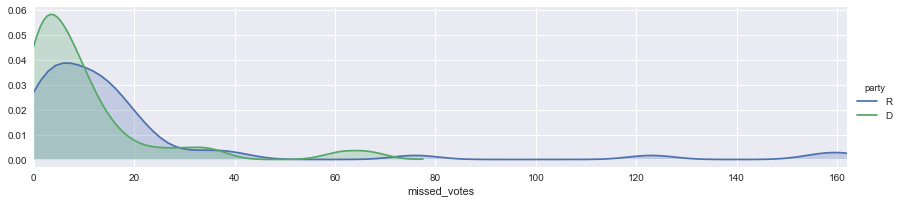

In [18]:
plot_distribution(senators[senators['party']!='I'], 'missed_votes', 'party')

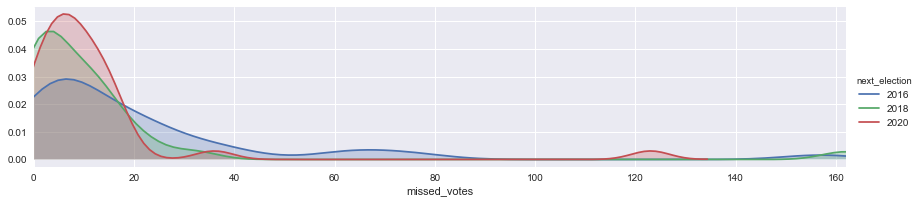

In [19]:
plot_distribution(senators[senators['party']!='I'], 'missed_votes', 'next_election')

Let's look at the number of senators up for reelection by party. 

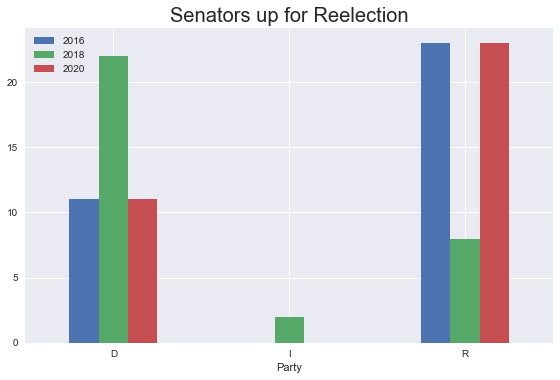

In [20]:
senators.groupby(['party', 'next_election']).size().unstack().plot(kind='bar', stacked=False)
plt.style.use('fivethirtyeight')
plt.legend(loc=0)
plt.title('Senators up for Reelection')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/up4reelection.png')

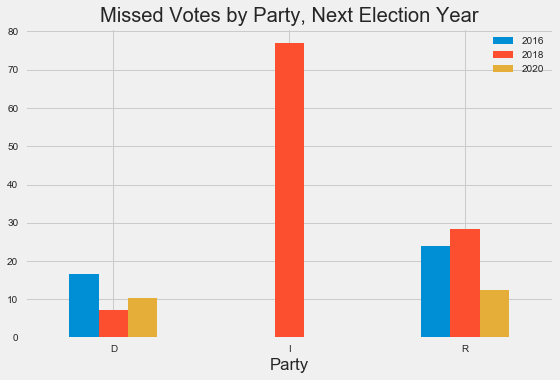

In [21]:
senators.groupby(['party', 'next_election'])['missed_votes'].mean().unstack().plot(kind='bar', stacked=False)
plt.legend(loc=0)
plt.title('Missed Votes by Party, Next Election Year')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/missed_votes_elec.png')

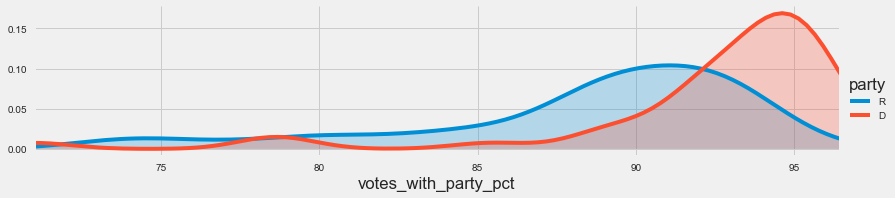

In [22]:
plot_distribution(senators[senators['party']!='I'], 'votes_with_party_pct', 'party')
plt.savefig('../gallery/votes_with_party_distribution')

In [23]:
senators.groupby('party')['votes_with_party_pct'].describe()

party       
D      count    44.000000
       mean     92.305455
       std       5.067455
       min      70.990000
       25%      91.810000
       50%      93.890000
       75%      95.077500
       max      96.410000
I      count     2.000000
       mean     88.765000
       std       0.530330
       min      88.390000
       25%      88.577500
       50%      88.765000
       75%      88.952500
       max      89.140000
R      count    54.000000
       mean     88.345370
       std       5.317825
       min      73.610000
       25%      87.227500
       50%      89.680000
       75%      92.250000
       max      94.420000
Name: votes_with_party_pct, dtype: float64

## The roll call votes

In [24]:
bills.head()

,vote_number,vote_date,issue,title,yea,nay,result,question
1,1,2015-01-08,H.R. 26,Warren Amdt. No. 1; In the nature of a substit...,31,66,Rejected,On the Amendment
2,2,2015-01-08,H.R. 26,H.R. 26; A bill to extend the termination date...,93,4,Passed,On Passage of the Bill
3,3,2015-01-12,S. 1,Motion to Invoke Cloture on the Motion to Proc...,63,32,Agreed to,On Cloture on the Motion to Proceed
4,4,2015-01-20,S. 1,Motion to Table Markey Amdt. No. 13; To ensure...,57,42,Agreed to,On the Motion to Table
5,5,2015-01-20,S. 1,Motion to Table Franken Amdt. No. 17; To requi...,53,46,Agreed to,On the Motion to Table


Let's take a closer look at the distribution of questions

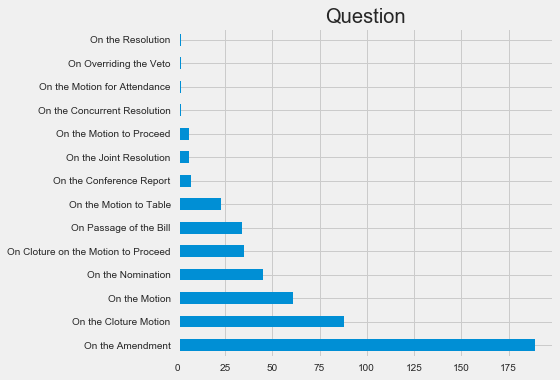

In [25]:
bills.question.value_counts().plot(kind='barh')
plt.title('Question')
plt.tight_layout()
plt.savefig('../gallery/questions_counted.png')
plt.show()

Most votes were amendments. 

Let's find the most controversial bills. These bills will have values in `yea` and `nay` that are very closer to each other. We'll create an index of these bills. 

In [26]:
# find divisive bills
diffs = abs(bills.yea - bills.nay)

In [27]:
controversial_bills = diffs.sort_values()[:100].index.values

In [28]:
# look at the titles 
print (bills.iloc[controversial_bills-1, :].head(10).title.values)

[ "Motion to Waive Applicable Budgetary Discipline Bennet Amdt. No. 1115; To protect and retain our Children's Health Insurance Program for 4 years (PRO-CHIP)."
 'Motion to Waive All Applicable Budgetary Discipline Re: Shaheen Amdt. No. 3345; To make appropriations to address the heroin and opioid drug abuse epidemic for the fiscal year ending September 30, 2016.'
 'Motion to Invoke Cloture on the Motion to Concur in the House Amendment with an Amendment; A bill to reauthorize and amend the National Sea Grant College Program Act, and for other purposes.'
 'Gillibrand Amdt. No. 1578; To reform procedures for determinations to proceed to trial by court-martial for certain offenses under the Uniform Code of Military Justice.'
 'Coats Amdt. No. 3814; To limit the use of funds made available for the Advanced Technology Vehicles Manufacturing Loan Program.'
 'Motion to Waive Applicable Budgetary Discipline Cotton Amdt. No. 664; To establish a deficit-neutral reserve fund relating to construc

Which issues are the most important? Which issues have the most votes associated with them? 

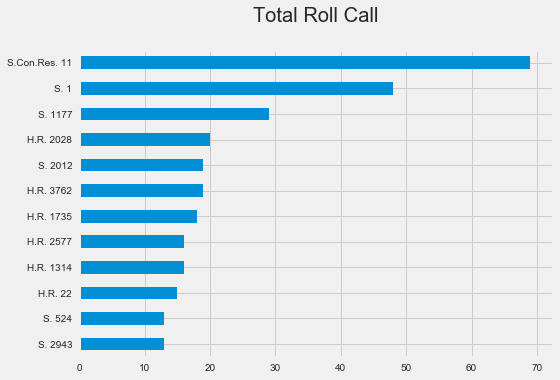

In [29]:
bills.issue.value_counts()[:12].sort_values().plot(kind='barh')
plt.title('Total Roll Call\n')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/rollcalls_issue.png')
plt.show()

In [36]:
bs = bills.issue.value_counts()[:12].sort_values()

The top 3 bills accounted for 41% of roll call votes. 

Are any days especially busy for senators? Which days and months have the most roll calls? 

In [30]:
bills['vote_month'] = bills.vote_date.apply(lambda x: x.month)

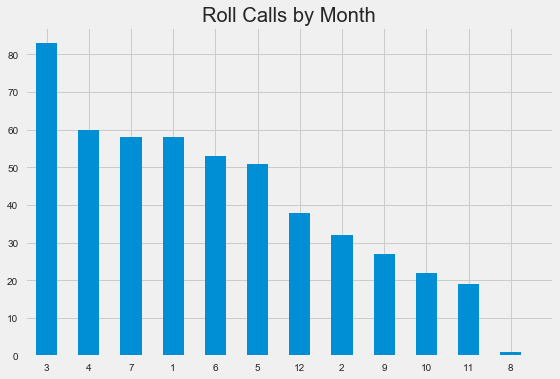

In [31]:
vals = bills.groupby('vote_month').size().sort_values(ascending=False)
labs = [str(x).split(' ')[0] for x in bills.groupby('vote_month').size().sort_values(ascending=False).index]
vals.plot(kind='bar')
plt.tight_layout()
plt.xticks(range(13), labs, rotation=0)
plt.xlabel('')
plt.title('Roll Calls by Month')
plt.savefig('../gallery/rollcalls_month.png')
plt.show()

March is busy

In [32]:
import matplotlib.pyplot as plt